# Make a summary of the bouts of a bird (alsa for now), curated and non-curated
- Make a df of all the files, days, (auto, curated)
- Load all the files (exclude the raw, spectrogram)
- Get the timestamps for each
- Plot spectrograms by day, and within day

In [1]:
import os
import glob
import socket
import logging
import pickle
import numpy as np
import pandas as pd

from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

logger.info('Running on {}'.format(socket.gethostname()))

2022-12-28 10:46:54,266 root         INFO     Running on pakhi.ucsd.edu


In [2]:
from ceciestunepipe.file import bcistructure as et
from ceciestunepipe.util.sound import boutsearch as bs
from ceciestunepipe.pipeline import searchbout as sb

In [209]:
reload(et)
sess_par = {'bird': 's_b1321_22',
           'acq_software': 'alsa',
           'derived_folder': 'bouts_ceciestunepipe',
           'auto_file': 'bout_auto_file',
           'curated_file': 'bout_curated_file',
           'super_session': 'all-sess-01'}



In [23]:
def list_sessions(sess_par: dict) -> np.array:
    sess_arr = np.array(et.list_sessions(sess_par['bird'], section='raw', 
                                     ephys_software=sess_par['acq_software']))
    sess_arr.sort()
    return sess_arr

sess_arr = list_sessions(sess_par)
sess_arr[:2]

array(['2022-10-10', '2022-10-11'], dtype='<U10')

In [31]:
def get_bird_sess_pd(sess_par: dict) -> pd.DataFrame:
    # go through all sessions with raw data and check which one has auto bouts, curated bouts.
    # get the sess_arr of raw, which ever raw is
    sess_arr = list_sessions(sess_par)
    sess_pd = pd.DataFrame({'sess': sess_arr})
    sess_pd['acq_soft'] = sess_par['acq_software']
    
    # see which has auto bouts
    sess_pd['has_auto_bouts'] = sess_pd['sess'].apply(lambda x: sb.has_bouts_file(sess_par['bird'], x, sess_par['acq_software'],
                                                                                  derived_folder=sess_par['derived_folder'],
                                                                                  bout_type=sess_par['auto_file'])
                                                     )
    
    if 'curated_file' in sess_par.keys():
        sess_pd['has_curated_bouts'] = sess_pd['sess'].apply(lambda x: sb.has_bouts_file(sess_par['bird'], x, sess_par['acq_software'],
                                                                                  derived_folder=sess_par['derived_folder'],
                                                                                  bout_type=sess_par['curated_file'])
                                                     )
    else:
        sess_pd['has_curated_bouts'] = None

    return sess_pd

spd = get_bird_sess_pd(sess_par)
spd.head()

2022-12-28 11:15:58,611 ceciestunepipe.pipeline.searchbout INFO     Search/bouts file not found in /mnt/sphere/speech_bci/derived_data/s_b1321_22/2022-12-28/alsa/bouts_ceciestunepipe
2022-12-28 11:15:58,636 ceciestunepipe.pipeline.searchbout INFO     Search/bouts file not found in /mnt/sphere/speech_bci/derived_data/s_b1321_22/2022-12-28/alsa/bouts_ceciestunepipe


,sess,acq_soft,has_auto_bouts,has_curated_bouts
0,2022-10-10,alsa,True,True
1,2022-10-11,alsa,True,True
2,2022-10-12,alsa,True,True
3,2022-10-13,alsa,True,True
4,2022-10-14,alsa,True,True


In [32]:
np.sum(spd['has_auto_bouts']==True)

77

In [45]:
reload(bs)

<module 'ceciestunepipe.util.sound.boutsearch' from '/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/sound/boutsearch.py'>

In [112]:
def load_bouts_ds(s_ds: pd.Series, sess_par: dict, 
                  file_key: str='auto_file', exclude_cols=[]) -> pd.DataFrame:
    # Load the bouts for a data series, exclude the cols, if any and return the loaded bout
    hparams, b_pd = sb.load_bouts(sess_par['bird'], s_ds['sess'], sess_par['acq_software'],
                                  derived_folder = sess_par['derived_folder'],
                                  bout_file_key = sess_par[file_key])
    b_pd['sess'] = s_ds['sess']
    
    return b_pd.drop(columns=exclude_cols)

one_sess_bpd = load_bouts_ds(spd.iloc[0], sess_par, exclude_cols=['waveform', 'spectrogram'])
one_sess_bpd.head(1)

,start_ms,end_ms,start_sample,end_sample,p_step,rms_p,peak_p,bout_check,file,len_ms,syl_in,n_syl,peaks_p,n_peaks,l_p_ratio,valid_waveform,valid,sess
0,1167630,1176065,56046240,56451120,"[1.167264651184038, 1.17760917174465, 4.185401...",0.652903,81.330653,True,/mnt/sphere/speech_bci/raw_data/s_b1321_22/202...,8435,"[[1167630, 1167685], [1167700, 1167735], [1167...",11,"[4, 18, 30, 37, 48, 56, 65, 73, 81, 103, 114, ...",26,324.423077,True,True,2022-10-10


In [51]:
spd.loc[spd['has_auto_bouts']].apply(lambda s: load_bouts_ds(s, sess_par, exclude_cols=exclude_cols))

NameError: name 'exclude_cols' is not defined

In [133]:
def load_all_bouts(sess_par: dict, exclude_cols: list=['waveform', 'spectrogram', 'p_step']) -> tuple:
    # get the pandas with the sessions
    logger.info('Looking for all sessions with bouts detected/curated for bird {}'.format(sess_par['bird']))
    s_pd = get_bird_sess_pd(sess_par)
    n_auto = np.sum(spd['has_auto_bouts']==True)
    n_curated = np.sum(spd['has_curated_bouts']==True)
    logger.info('Found {} sessions with detected, {} with curated bouts'.format(n_auto, n_curated))
    
    # load all curated, drop the
    sel_auto = s_pd['has_auto_bouts']
    auto_bout_pd_list = list(s_pd.loc[sel_auto].apply(lambda s: load_bouts_ds(s, sess_par, 
                                                                              exclude_cols=exclude_cols,
                                                                             file_key='auto_file'), 
                                                      axis=1))
    auto_bout_pd = pd.concat(auto_bout_pd_list).rename(columns={'bout_check': 'bout_auto'})    
    if sess_par['acq_software'] == 'alsa':
        auto_bout_pd = bs.alsa_bout_time_stamps(auto_bout_pd)
    
    
    # auto bout ready to merge with curated bouts, wherever they exist
    # load the curated, wherever they exist, and if it is within the session parameters plan
    if 'curated_file' in sess_par.keys():
        sel_curated = s_pd['has_curated_bouts']
        check_bout_pd_list = list(s_pd.loc[sel_curated].apply(lambda s: load_bouts_ds(s, sess_par, 
                                                                                   exclude_cols=exclude_cols,
                                                                                  file_key='curated_file'), 
                                                           axis=1))
        check_bout_pd = pd.concat(check_bout_pd_list)
        if sess_par['acq_software'] == 'alsa':
            check_bout_pd = bs.alsa_bout_time_stamps(check_bout_pd)
        
        # do the merge now
        bout_pd = auto_bout_pd.merge(check_bout_pd[['t_stamp', 'is_call', 'confusing', 'bout_check']], 
                                     on='t_stamp', 
                                     how='outer')
    else:
        bout_pd = auto_bout_pd

    bout_pd['datetime'] = pd.to_datetime(bout_pd['t_stamp'])
    bout_pd['day'] = bout_pd['datetime'].apply(lambda dt: dt.strftime('%Y-%m-%d'))
    bout_pd['hour'] = bout_pd['datetime'].apply(lambda x: x.hour)
    return bout_pd
                                                
all_bout_pd = load_all_bouts(sess_par)

2022-12-28 13:21:24,057 root         INFO     Looking for all sessions with bouts detected/curated for bird s_b1321_22
2022-12-28 13:21:24,195 ceciestunepipe.pipeline.searchbout INFO     Search/bouts file not found in /mnt/sphere/speech_bci/derived_data/s_b1321_22/2022-12-28/alsa/bouts_ceciestunepipe
2022-12-28 13:21:24,222 ceciestunepipe.pipeline.searchbout INFO     Search/bouts file not found in /mnt/sphere/speech_bci/derived_data/s_b1321_22/2022-12-28/alsa/bouts_ceciestunepipe
2022-12-28 13:21:24,224 root         INFO     Found 77 sessions with detected, 35 with curated bouts
2022-12-28 13:22:31,851 ceciestunepipe.util.sound.boutsearch WARNING  Non split recording detected in file /mnt/sphere/speech_bci/raw_data/s_b1321_22/2022-11-23/alsa/12-00-01.wav
2022-12-28 13:22:31,853 ceciestunepipe.util.sound.boutsearch WARNING  Non split recording detected in file /mnt/sphere/speech_bci/raw_data/s_b1321_22/2022-11-23/alsa/12-00-01.wav


In [207]:
et.get_exp_struct(sess_par['bird'], '', ephys_software='alsa')

{'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1321_22',
  'raw': '/mnt/sphere/speech_bci/raw_data/s_b1321_22/',
  'alsa': '/mnt/sphere/speech_bci/raw_data/s_b1321_22/alsa',
  'kwik': '/scratch/earneodo/s_b1321_22/alsa/kwik/',
  'processed': '/mnt/sphere/speech_bci/processed_data/s_b1321_22/alsa',
  'derived': '/mnt/sphere/speech_bci/derived_data/s_b1321_22/alsa',
  'tmp': '/scratch/earneodo/tmp',
  'msort': '/scratch/earneodo/s_b1321_22/alsa/msort/',
  'ksort': '/scratch/earneodo/s_b1321_22/alsa/ksort/',
  'sort': '/mnt/sphere/speech_bci/derived_data/s_b1321_22/alsa/'},
 'files': {'par': '/scratch/earneodo/s_b1321_22/alsa/ksort/params.json',
  'set': '/mnt/sphere/speech_bci/raw_data/s_b1321_22/alsa/settings.isf',
  'rig': '/mnt/sphere/speech_bci/raw_data/s_b1321_22/alsa/rig.json',
  'kwd': '/scratch/earneodo/s_b1321_22/alsa/kwik/stream.kwd',
  'kwik': '/scratch/earneodo/s_b1321_22/alsa/kwik/sort_/spikes.kwik',
  'kwe': '/scratch/earneodo/s_b1321_22/alsa/kwik/events.kwe',
  '

In [ ]:
def load_all_bouts_file(

In [175]:
all_bout_pd.head(2)

,start_ms,end_ms,start_sample,end_sample,rms_p,peak_p,bout_auto,file,len_ms,syl_in,...,sess,t_stamp,is_call,confusing,bout_check,datetime,day,time,min,hour
0,1167630,1176065,56046240,56451120,0.652903,81.330653,True,/mnt/sphere/speech_bci/raw_data/s_b1321_22/202...,8435,"[[1167630, 1167685], [1167700, 1167735], [1167...",...,2022-10-10,2022-10-10 17:19:28.630,True,False,True,2022-10-10 17:19:28.630,2022-10-10,17-10-28,1677-09-21 00:12:43.145224193,17
1,1003915,1007215,48187920,48346320,0.809800,59.454740,True,/mnt/sphere/speech_bci/raw_data/s_b1321_22/202...,3300,"[[1003915, 1003950], [1003975, 1004045], [1004...",...,2022-10-10,2022-10-10 18:46:44.915,True,False,True,2022-10-10 18:46:44.915,2022-10-10,18-10-44,1677-09-21 00:12:43.145224193,18


In [210]:
reload(sb)
sb.save_bouts_summary(all_bout_pd, sess_par['bird'],
                      sess=sess_par['super_session'],
                      acq_soft=sess_par['acq_software'],
                      derived_folder=sess_par['derived_folder'])

2022-12-29 00:01:35,150 ceciestunepipe.pipeline.searchbout INFO     Saving bout summary dataframe
2022-12-29 00:01:35,151 ceciestunepipe.pipeline.searchbout INFO     Bout summary path is /mnt/sphere/speech_bci/processed_data/s_b1321_22/alsa/bouts_ceciestunepipe/bout_summary_df.pickle


'/mnt/sphere/speech_bci/processed_data/s_b1321_22/alsa/bouts_ceciestunepipe/bout_summary_df.pickle'

In [ ]:
abdf = sb.load_bouts_summary(sess_par['bird'],
                      sess=sess_par['super_session'],
                      acq_soft=sess_par['acq_software'],
                      derived_folder=sess_par['derived_folder'])

In [141]:
np.sum(all_bout_pd['confusing']==True)

86

In [148]:
from matplotlib import pyplot as plt
%matplotlib inline

<AxesSubplot:xlabel='datetime'>

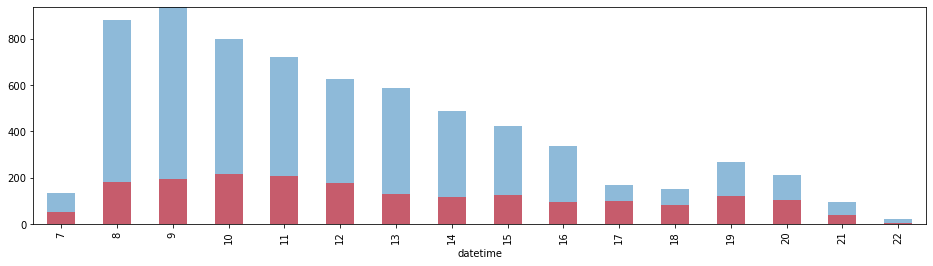

In [203]:
fig, axs = plt.subplots(figsize=(16, 4))
all_bout_pd['bout_check'].fillna(False, inplace=True)
all_bout_pd.groupby(all_bout_pd['datetime'].dt.hour)['bout_auto'].sum().plot(kind='bar', ax=axs, alpha=0.5)
all_bout_pd.groupby(all_bout_pd['datetime'].dt.hour)['bout_check'].sum().plot(kind='bar', ax=axs, alpha=0.5, color='red')

<AxesSubplot:xlabel='datetime'>

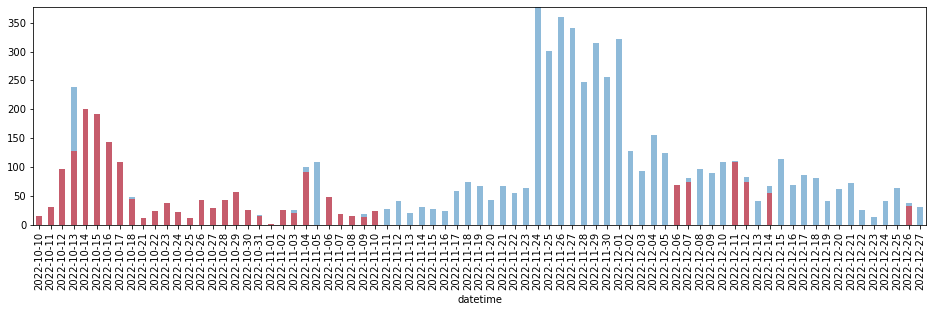

In [202]:
fig, axs = plt.subplots(figsize=(16, 4))
all_bout_pd['bout_check'].fillna(False, inplace=True)
all_bout_pd.groupby(all_bout_pd['datetime'].dt.date)['bout_auto'].sum().plot(kind='bar', ax=axs, alpha=0.5)
all_bout_pd.groupby(all_bout_pd['datetime'].dt.date)['bout_check'].sum().plot(kind='bar', ax=axs, alpha=0.5, color='red')